***
#### **For keep all lib**
`python -m pip freeze > requirements.txt`
#### **For install all lib**
`python -m pip install -r requirements.txt`
#### **For clean all lib use**
`python -m pip uninstall -y -r <(pip freeze)`

***
#### **install torch torchvision torchaudio**
`pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117`
#### **install detectron2**
`git clone https://github.com/facebookresearch/detectron2.git`
***
`python -m pip install -e detectron2`
***

In [2]:
import torch, detectron2

c:\Users\Admin\Desktop\WORK\MastersDegree\BoxjourneyProject\WorkSpace\.env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())

True


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0


In [5]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__
# print(torch.cuda.is_available())
print("torch: ", TORCH_VERSION, "; cuda: ", torch.__version__)
print("detectron2:", detectron2.__version__)

torch:  1.13 ; cuda:  1.13.1+cu117
detectron2: 0.6


In [6]:
!nvidia-smi

Mon Jan 16 23:41:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8    17W /  81W |    645MiB /  8192MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from os import path as p
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

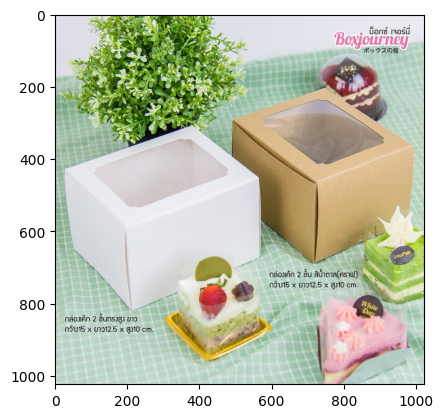

In [23]:
# im = cv2.imread("./img/1.jpeg")
# im = cv2.imread("./img/2.jpeg")
im = cv2.imread("./img/cake/c_1.jpg")
# im = cv2.imread("./img/cake/c_3.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# call imshow() using plt object
plt.imshow(im)

In [9]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[01/16 23:41:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


c:\Users\Admin\Desktop\WORK\MastersDegree\BoxjourneyProject\WorkSpace\.env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([55, 41, 60, 42, 44], device='cuda:0')
Boxes(tensor([[ 232.4096,  792.1057,  492.3001,  946.7585],
        [   3.0713,  766.4091,  141.4501,  931.5381],
        [   1.4988,  772.9227,  677.7102, 1015.6248],
        [  94.2576,  843.2734,  163.9146,  946.9171],
        [ 101.6250,  842.1281,  168.3381,  942.0974]], device='cuda:0'))


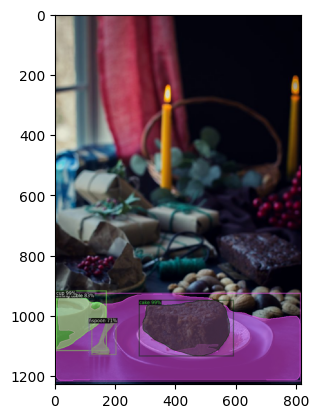

In [11]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
result_image = out.get_image()[:, :, ::-1]

plt.imshow(result_image)

In [20]:
# available classes
classes = outputs["instances"].pred_classes.cpu().numpy()
print(classes)

# available boxes
boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
print(boxes)

[55 41 60 42 44]
[[ 232.40959    792.1057     492.30008    946.75854  ]
 [   3.0712688  766.4091     141.45015    931.5381   ]
 [   1.4987954  772.92267    677.7102    1015.62476  ]
 [  94.25758    843.27344    163.9146     946.9171   ]
 [ 101.625046   842.12805    168.3381     942.0974   ]]


In [21]:
def get_cropped_image(image, box):
    x1, y1, x2, y2 = box
    return image[int(y1):int(y2), int(x1):int(x2)]

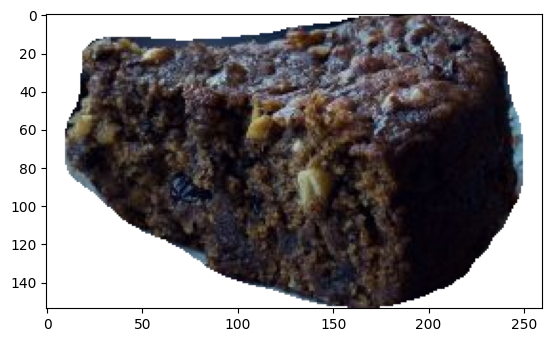

In [22]:
temp_mask_image = []
for i in range(len(classes)):
  class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[classes[i]]
  class_score = outputs["instances"].scores[i].cpu().numpy()
  if class_name in ["cake"]:
    mask = outputs["instances"].pred_masks[i].cpu().numpy()
    boxes_mask = boxes[i]
    tmp_image = im.copy()
    r = len(mask[0])
    j = len(mask)
    for j1 in range(j):
      for r1 in range(r):
        if(mask[j1][r1] == False):
          tmp_image[j1,r1] = 255
    tmp_image = get_cropped_image(tmp_image, boxes_mask)
    temp_mask_image.append({
        "class_name": class_name,
        "class_score": class_score,
        "mask_image": tmp_image,
    })

best_mask_image = None
for image in temp_mask_image:
  if best_mask_image == None:
    best_mask_image = image
  if image["class_score"] > best_mask_image["class_score"]:
    best_mask_image = image

plt.imshow(best_mask_image["mask_image"])
plt.show()